In [1]:
import os
os.chdir('..')

import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from data_provider.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

dataset = Dataset_ETT_hour(
    root_path='./dataset/ETT-small/',
    data_path='ETTh1.csv',
    flag='train',
    size=[96, 48, 96],
    features='M',
    target='OT',
    timeenc=1,
    freq='h',
)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=False,
    num_workers=10,
    drop_last=True
)

In [3]:
batch_x, batch_y, batch_x_mark, batch_y_mark = next(iter(dataloader))

batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape

(torch.Size([32, 96, 7]),
 torch.Size([32, 144, 7]),
 torch.Size([32, 96, 4]),
 torch.Size([32, 144, 4]))

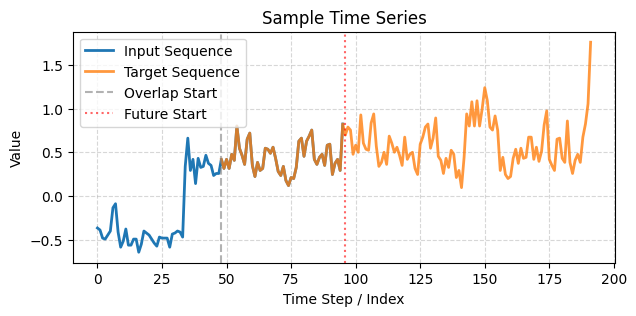

In [4]:
from utils.plotters import plot_series

plot_series(batch_x[0,:,0].numpy(), batch_y[0,:,0].numpy(), label_len=48, label_x='Input Sequence', label_y='Target Sequence', title='Sample Time Series')

In [5]:
from layers.ema import Decomp

decomp = Decomp(alpha=0.1)

trend, season = decomp(batch_x)

trend.shape, season.shape

(torch.Size([32, 96, 7]), torch.Size([32, 96, 7]))

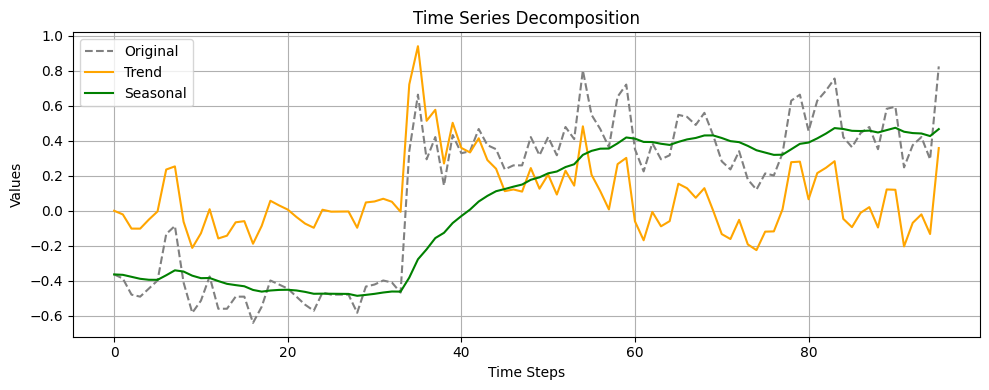

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(batch_x[0,:,0].numpy(), label='Original', color='gray', linestyle='--')
plt.plot(trend[0,:,0].detach().numpy(), label='Trend', color='orange')
plt.plot(season[0,:,0].detach().numpy(), label='Seasonal', color='green')
plt.title('Time Series Decomposition')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

In [16]:
def ACF_for_Seasonal(x, k=2, min_period=4, acf_threshold=0.15):
    """
    针对 Seasonal 成分提取 Top-K 周期
    """
    B, T, C = x.shape
    x_centered = x - x.mean(dim=1, keepdim=True)
    n_fft = 1 << (2 * T - 1).bit_length()
    xf = torch.fft.rfft(x_centered, n=n_fft, dim=1)
    acf = torch.fft.irfft(xf * torch.conj(xf), n=n_fft, dim=1)[:, :T, :]
    avg_acf = acf.mean(dim=0) # [T, C]
    
    # 归一化 ACF 以应用阈值过滤器
    norm_acf = avg_acf / (avg_acf[0, :] + 1e-9)
    norm_acf[:min_period, :] = -float('inf')
    
    prev_lag = torch.roll(norm_acf, 1, dims=0)
    next_lag = torch.roll(norm_acf, -1, dims=0)
    # NOTE: 识别峰值且必须超过阈值，增强对 Seasonal 噪声的鲁棒性
    is_peak = (norm_acf > prev_lag) & (norm_acf > next_lag) & (norm_acf > acf_threshold)
    
    masked_acf = norm_acf.clone()
    masked_acf[~is_peak] = -float('inf')
    
    top_vals, top_inds = torch.topk(masked_acf, k, dim=0)
    # 若无显著周期，回退到全长 T
    final_periods = torch.where(top_vals > -float('inf'), top_inds, torch.full_like(top_inds, T))
    return final_periods.t() # [C, k]

In [18]:
ACF_for_Seasonal(season, k=3, min_period=4, acf_threshold=0.1)

tensor([[ 4, 96, 96],
        [ 4, 96, 96],
        [ 4, 96, 96],
        [ 4, 96, 96],
        [ 4, 96, 96],
        [ 4, 96, 96],
        [ 4, 96, 96]])